In [1]:
%load_ext autoreload 
%autoreload 2
import sys
import pandas as pd
pd.options.display.max_rows=100
pd.options.display.min_rows=100
pd.options.display.max_colwidth=120
sys.path.insert(0, '/SSF')
import os
os.chdir('/SSF')

In [2]:
from DejaVu.explib import get_eval_results
eval_rets, _ = get_eval_results()

Using backend: pytorch


download finished


In [3]:
from pathlib import Path
OUTPUT_DIR = Path("/SSF/output/plot_performance_to_failure_frequency/")
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

In [4]:
import torch as th
from DejaVu.explib import read_model
from DejaVu.models import get_GAT_model
from pathlib import Path
from typing import Union
from loguru import logger
from functools import lru_cache
logger.remove()

@lru_cache(maxsize=None)
def get_rank_df_from_exp_dir(exp_dir: Union[str, Path]):
    exp_dir = Path(exp_dir)
    model, y_probs, y_preds = read_model(exp_dir, get_GAT_model, override_config=dict(flush_dataset_cache=False))
    ret_df = []
    for fid in model.test_failure_ids:
        ret_df.append({
            'first_rank': min(y_preds[fid].tolist().index(model.fdg.instance_to_gid(_)) + 1 for _ in model.fdg.root_cause_instances_of(fid)),
            'average_rank': sum(
                y_preds[fid].tolist().index(model.fdg.instance_to_gid(_)) + 1 for _ in model.fdg.root_cause_instances_of(fid)
            ) / len(model.fdg.root_cause_instances_of(fid)),
            "failure_class": model.fdg.instance_to_local_id(model.fdg.root_cause_instances_of(fid)[0])[0],
            'fid': fid,
        })
    ret_df = pd.DataFrame.from_records(ret_df)
    ret_df['failure_class_count'] = ret_df['failure_class'].map(
        lambda fc: len({fid for fid in model.train_failure_ids if fc in {model.fdg.instance_to_local_id(_)[0] for _ in model.fdg.root_cause_instances_of(fid)}})
    )
    return ret_df

# get_rank_df_from_exp_dir("/data/SSF/experiment_outputs/run_GAT_node_classification.py.2021-12-22T03:17:22.642597")

In [5]:
from concurrent.futures import ProcessPoolExecutor
@lru_cache
def get_ranks_df_from_paths(dataset, n_jobs=10):
    paths = eval_rets.loc[
        (eval_rets.Dataset.str.contains(dataset)) & 
        (eval_rets.Method == 'GRU+GAT-H4-L8+BAL'),
        '实验路径'
    ].values
    
    ranks_df_list = []
    ranks_df_list.append(get_rank_df_from_exp_dir(paths[0]))
    
    for path in paths[1:]:
        ranks_df_list.append(get_rank_df_from_exp_dir(path))
    ranks_df = pd.concat(ranks_df_list)
    # ranks_df = pd.concat([get_rank_df_from_exp_dir(_) for _ in tqdm(paths)])
    # display(ranks_df)
    tf_count_df = ranks_df.set_index('failure_class')['failure_class_count'].reset_index().drop_duplicates().groupby('failure_class')['failure_class_count'].sum()
    display(tf_count_df)
    ranks_df['#Training Failures'] = ranks_df['failure_class'].map(lambda _: tf_count_df.loc[_])
    return ranks_df

In [6]:
dfa = get_ranks_df_from_paths("AIOPS20")
dfa['Dataset'] = 'A'
dfa.to_pickle(OUTPUT_DIR / "dfa.pkl")

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:906: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have m

KeyboardInterrupt: 

In [ ]:
dfb = get_ranks_df_from_paths("AIOPS21")
dfb['Dataset'] = 'B'
dfb.to_pickle(OUTPUT_DIR / "dfb.pkl")

In [ ]:
dfc = get_ranks_df_from_paths("CCB-Oracle")
dfc['Dataset'] = 'C'
dfc.to_pickle(OUTPUT_DIR / "dfc.pkl")

In [ ]:
dfd = get_ranks_df_from_paths("D-20220306", n_jobs=1)
dfd['Dataset'] = 'D'
dfd.to_pickle(OUTPUT_DIR / "dfd.pkl")

In [7]:
import pandas as pd
dfa = pd.read_pickle(OUTPUT_DIR / 'dfa.pkl')
dfb = pd.read_pickle(OUTPUT_DIR / 'dfb.pkl')
dfc = pd.read_pickle(OUTPUT_DIR / 'dfc.pkl')
dfd = pd.read_pickle(OUTPUT_DIR / 'dfd.pkl')
df = pd.concat([dfa, dfb, dfc, dfd])

In [10]:
def _group(n):
    if n < 0:
        return f"{{{n}}}"
    else:
        unit = 5
        return f"[{n // unit * unit}, {n // unit * unit + unit})"
df = df.sort_values(by="#Training Failures")
df["log_rank"] = df.eval("log(average_rank) / log(2)")
df["#train_failures_group"] = df["#Training Failures"].map(_group)
df

,first_rank,average_rank,failure_class,fid,failure_class_count,#Training Failures,Dataset,log_rank,#train_failures_group
33,1,1.0,Memory,34,1,1,C,0.000000,"[0, 5)"
37,1,1.0,Disk,88,1,1,C,0.000000,"[0, 5)"
36,1,1.0,CacheLock,55,1,1,C,0.000000,"[0, 5)"
33,1,1.0,Memory,34,1,1,C,0.000000,"[0, 5)"
33,1,1.0,Memory,34,1,1,C,0.000000,"[0, 5)"
36,1,1.0,CacheLock,55,1,1,C,0.000000,"[0, 5)"
37,1,1.0,Disk,88,1,1,C,0.000000,"[0, 5)"
33,1,1.0,Memory,34,1,1,C,0.000000,"[0, 5)"
37,1,1.0,Disk,88,1,1,C,0.000000,"[0, 5)"
37,2,2.0,Disk,88,1,1,C,1.000000,"[0, 5)"


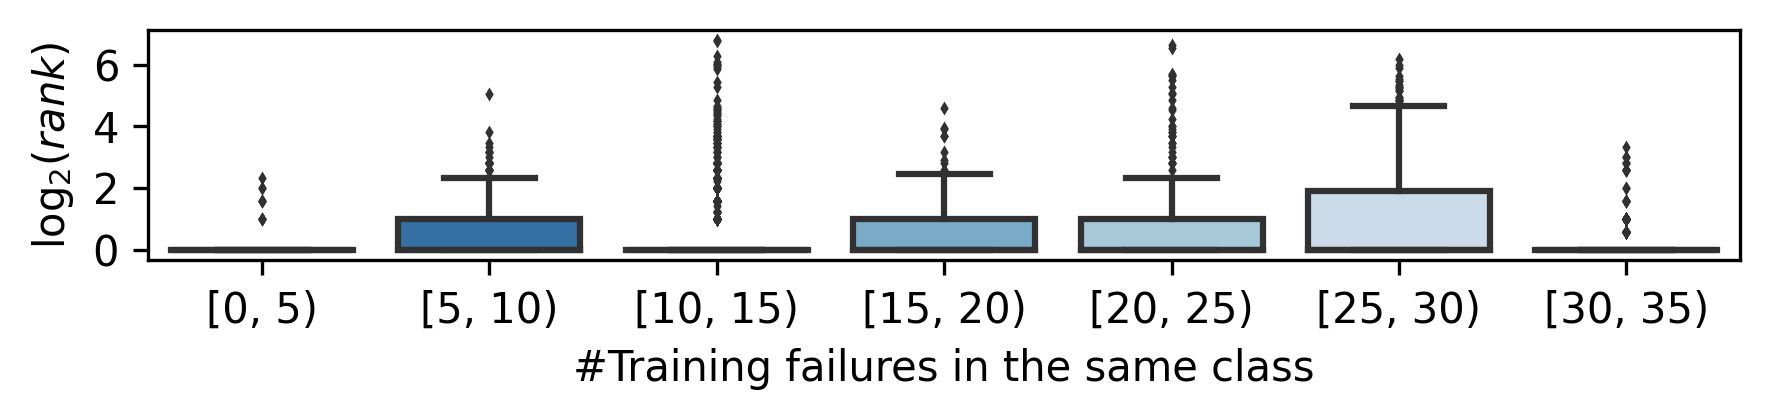

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.figure(dpi=300, figsize=(6, 1.5))
sns.boxplot(data=df, x="#train_failures_group", y="log_rank", fliersize=1, palette="Blues_r")
plt.xlabel("#Training failures in the same class")
plt.ylabel("$\log_{2}(rank)$")
plt.xticks(rotation=0)
plt.yticks([0, 2, 4, 6])
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "performance_to_failure_frequency.pdf", bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()